In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.util import ngrams
import string
import unidecode
import random
import torch

# Prevent kernel from dying
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

/Users/faustotnc/.pyenv/versions/3.8.5/lib/python3.8/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
# Reads the data
labeledPfd = pd.read_csv("./datasets/LabeledPoetryFoundationPoems.csv")


# Filters the poems by category
def get_poems_by_category(category):
    data = []
    for poem, emotion in zip(labeledPfd["poem"], labeledPfd["emotion"]):
        if emotion == category:
            data.append(poem)
    return data


# The available poem categories
all_categories = ["joy", "trust", "sadness", "anticipation", "fear", "anger", "disgust", "surprise"]
# The number of categories we have
n_categories = len(all_categories)

# Gets the poems in each category
poems = {
    "joy": get_poems_by_category("joy"),
    "trust": get_poems_by_category("trust"),
    "sadness": get_poems_by_category("sadness"),
    "anticipation": get_poems_by_category("anticipation"),
    "fear": get_poems_by_category("fear"),
    "anger": get_poems_by_category("anger"),
    "disgust": get_poems_by_category("disgust"),
    "surprise": get_poems_by_category("surprise")
}

In [3]:
# Training with only 500 poems.
# When trying to train with the entrie dataset (~4000 poems)
# the kernel dies before completing the first epoch.
text = list(poems["joy"][:200])

def joinStrings(text):
    return ' '.join(string for string in text)
text = joinStrings(text)
len(text.split()) # Number of tokens

42262

In [4]:
# stop = set(nltk.corpus.stopwords.words('english'))
# exclude = set(string.punctuation) 
# lemma = nltk.stem.wordnet.WordNetLemmatizer()
# def clean(doc):
#         stop_free = " ".join([i for i in doc.split() if i not in stop])
#         punc_free = "".join(ch for ch in stop_free if ch not in exclude)
#         normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
#         return normalized

clean_data = nltk.word_tokenize(text)

In [5]:
# Generates trigram word embeddings
# with the data. For the sentence:
# "I party with my friends on the weekedns"
# "with", and "my" will be the context for
# the word "friends". An example is printed bellow
embeddings = [ ([trigram[0], trigram[1]], trigram[2]) for trigram in ngrams(clean_data, 4)]
chunk_len = len(embeddings)
print(embeddings[:3])

[(['Invisible', 'fish'], 'swim'), (['fish', 'swim'], 'this'), (['swim', 'this'], 'ghost')]


In [6]:
# Extracts the vocabulary
vocab = set(clean_data)
voc_len = len(vocab)

# Encodes the position of each word in the vocabulary
word_to_ix = {word: i for i, word in enumerate(vocab)}

In [7]:
# Creates the input and target vectors
inp, tar = ([], [])
for context, target in embeddings:
    context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)
    inp.append(context_idxs)
    targ = torch.tensor([word_to_ix[target]], dtype=torch.long)
    tar.append(targ)

In [8]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        
        # We are using the GRU method to train the model
        self.gru = nn.GRU(hidden_size*2, hidden_size, n_layers,batch_first=True,
                          bidirectional=False)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

In [9]:
def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0
    
    for c in range(chunk_len):
        print(c, "out of", chunk_len, end="\r")
        output, hidden = decoder(inp[c], hidden)
        loss += criterion(output, target[c])

    print("Performing back-propagation...", end="\r")
    
    loss.backward()
    decoder_optimizer.step()

    return loss.data.item() / chunk_len

In [10]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [11]:
n_epochs = 20
print_every = 1
plot_every = 1
hidden_size = 120 # 120 nodes on each hidden layer 
n_layers = 2 # two hidden layers
lr = 0.01 # learning rate

decoder = RNN(voc_len, hidden_size, voc_len, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

total_execution_time_
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    start = time.time()
    
    loss = train(inp, tar)       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 23s (1 5%) 9.0933]ation...
 41s (2 10%) 8.8929]tion...
 56s (3 15%) 7.9436]tion...
 19s (4 20%) 7.2803]ion...
 44s (5 25%) 6.9546]ion...
 9s (6 30%) 6.8849]tion...out of 48811 48811
 25s (7 35%) 6.9546]ion... 48811
 41s (8 40%) 6.9420]ion...
 56s (9 45%) 6.8750]ion...
 24s (10 50%) 6.8170]on...
 45s (11 55%) 6.7815]on...
 5s (12 60%) 6.7528]ion...
 30s (13 65%) 6.7262]on...
 52s (14 70%) 6.6906]on...
 12s (15 75%) 6.6476]on...
 33s (16 80%) 6.6060]on...
 51s (17 85%) 6.5640]on...
 9s (18 90%) 6.5188]ion...
 39s (19 95%) 6.4723]on... 48811
 54s (20 100%) 6.4249]n...


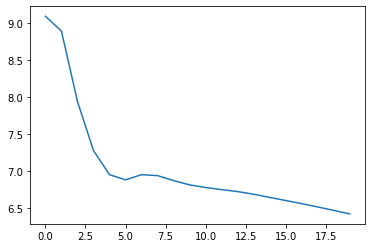

In [12]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

In [13]:
def predict(prime_str='this love', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden()

    for p in range(predict_len):
        prime_input = torch.tensor([word_to_ix[w] for w in prime_str.split()], dtype=torch.long)
        inp = prime_input[-2:] #last two words as input
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted word to string and use as next input
        predicted_word = list(word_to_ix.keys())[list(word_to_ix.values()).index(top_i)]
        prime_str += " " + predicted_word

    return prime_str

In [14]:
generated_poem = predict(prime_str='this love', predict_len=100, temperature=1)

print(generated_poem)

this love apocalypse inception hissing midnight—the his voices shuffle t I summer . you on the morning the dreamers much on you magpies touch scan s eventual calling shadows centenary known in We line ! of members red wounds strong , roof-top , in those gown up all the it places to moaned 58 , ! , with The is his and . off then , the toothed spangled Like the . leaves sends '' It did It Dawn-rose your future abusing Of , the eyes a . It kut all Simple buy that girl . The love . though . be
